# 🍕 Takeaway.com Data Analysis & Visualization
 
**Database:** Takeaway.com (Belgium)

---

## Project Overview

This notebook analyzes food delivery data from Takeaway.com to uncover insights about:
- Menu item pricing strategies
- Restaurant distribution across cities
- Top-rated restaurants by cuisine
- Vegetarian & vegan food availability

---

## Table of Contents

1. [Setup & Database Connection](#1-setup)
2. [Price Distribution Analysis](#2-price-distribution)
3. [Restaurant Distribution by City](#3-city-distribution)
4. [World Hummus Order (WHO) - Top 3 Restaurants](#4-hummus)
5. [Vegetarian & Vegan Availability Map](#5-veg-map)

---

<a id='1-setup'></a>
## 1. Setup & Database Connection

Import required libraries and establish connection to the SQLite database.

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import sys 
from IPython.display import IFrame

# Connect to SQLite database
conn = sqlite3.connect("takeaway.db")

---

<a id='2-price-distribution'></a>
## 2. Price Distribution of Menu Items

### Business Question
**What is the price distribution of menu items on the platform?**

### Why It Matters
Understanding price ranges helps identify:
- Market positioning of restaurants
- Consumer price sensitivity
- Opportunities for budget or premium offerings

### Methodology
- Group menu items into 5 price brackets: €0-5, €5-10, €10-15, €15-20, €20+
- Calculate count and percentage for each bracket
- Exclude items with null or zero prices (likely data errors)

In [2]:
# Price Distribution Query
# Note: Calculating percentage in Python for better SQLite compatibility
price_query = """
SELECT
    CASE
        WHEN price < 5 THEN '€0 - €5'
        WHEN price >= 5 AND price < 10 THEN '€5 - €10'
        WHEN price >= 10 AND price < 15 THEN '€10 - €15'
        WHEN price >= 15 AND price < 20 THEN '€15 - €20'
        ELSE '€20+'
    END AS price_range,
    COUNT(*) AS item_count,
    MIN(price) AS min_price
FROM menuItems
WHERE price IS NOT NULL 
  AND price > 0
GROUP BY 
    CASE
        WHEN price < 5 THEN '€0 - €5'
        WHEN price >= 5 AND price < 10 THEN '€5 - €10'
        WHEN price >= 10 AND price < 15 THEN '€10 - €15'
        WHEN price >= 15 AND price < 20 THEN '€15 - €20'
        ELSE '€20+'
    END
ORDER BY min_price;
"""

# Run query
df = pd.read_sql_query(price_query, conn)

# Calculate percentage in Python
df['percentage'] = round(df['item_count'] / df['item_count'].sum() * 100, 2)

# Drop helper column
df = df.drop(columns=['min_price'])

# Display the data
df

,price_range,item_count,percentage
0,€0 - €5,117945,29.27
1,€5 - €10,101797,25.27
2,€10 - €15,102999,25.56
3,€15 - €20,53713,13.33
4,€20+,26460,6.57


/var/folders/fz/fn63jcks2kx_4ngyvls8mp0w0000gn/T/ipykernel_81113/192610451.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


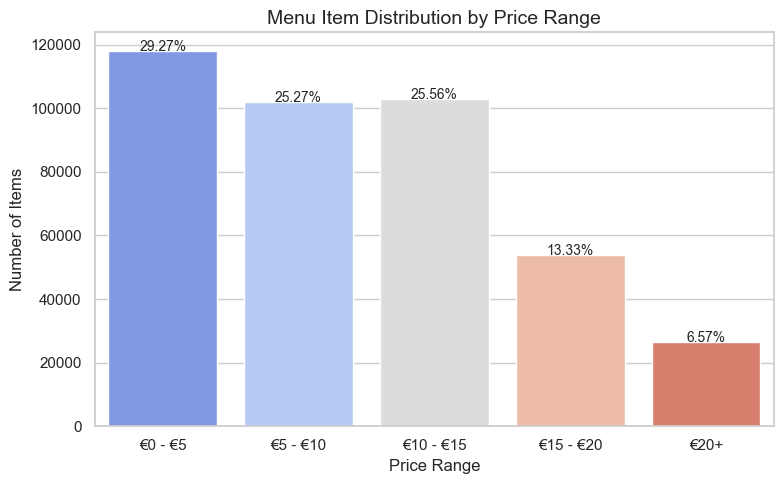

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))

# Bar chart: item count per price range
sns.barplot(
    data=df,
    x='price_range',
    y='item_count',
    palette='coolwarm'
)

# Add labels and title
plt.title('Menu Item Distribution by Price Range', fontsize=14)
plt.xlabel('Price Range', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)

# Show percentages above bars
for index, row in df.iterrows():
    plt.text(
        x=index, 
        y=row['item_count'] + 2,  # slightly above the bar
        s=f"{row['percentage']}%",
        ha='center',
        fontsize=10
    )

plt.tight_layout()
plt.show()

### 📊 Key Insights: Price Distribution

| Finding | Implication |
|---------|-------------|
| **Majority of items priced €5-€15** | The platform caters primarily to mid-range consumers |
| **Budget options (€0-€5) exist but limited** | Opportunity for more affordable menu items |
| **Premium items (€20+) are rare** | Platform positioned for everyday ordering, not fine dining |

**Business Recommendation:** Restaurants could differentiate by offering more budget-friendly options or premium specialty items to capture underserved segments.

---

<a id='3-city-distribution'></a>
## 3. Restaurant Distribution by City

### Business Question
**How are restaurants distributed across different cities?**

### Why It Matters
- Identifies market saturation in major cities
- Reveals expansion opportunities in underserved areas
- Helps understand competitive landscape

### Methodology
- Count unique restaurants per city
- Calculate market share percentage
- Focus on top 10 cities for visualization clarity

In [4]:
# Distribution of restaurant per location 

city_dist = """
SELECT
    l.city,
    COUNT(DISTINCT ltr.restaurant_id) AS restaurant_count,
    ROUND(
        COUNT(DISTINCT ltr.restaurant_id) * 100.0 /
        SUM(COUNT(DISTINCT ltr.restaurant_id)) OVER (),
        2
    ) AS market_share_pct
FROM locations l
INNER JOIN locations_to_restaurants ltr
    ON l.ID = ltr.location_id
WHERE l.city IS NOT NULL
GROUP BY l.city
ORDER BY restaurant_count DESC;
"""

df_city_dist = pd.read_sql_query(city_dist, conn)
df_city_dist.head()

,city,restaurant_count,market_share_pct
0,Antwerp,746,2.01
1,Haren,605,1.63
2,Ghent,377,1.02
3,Zaventem,306,0.83
4,Destelbergen,284,0.77


/var/folders/fz/fn63jcks2kx_4ngyvls8mp0w0000gn/T/ipykernel_81113/3824131690.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


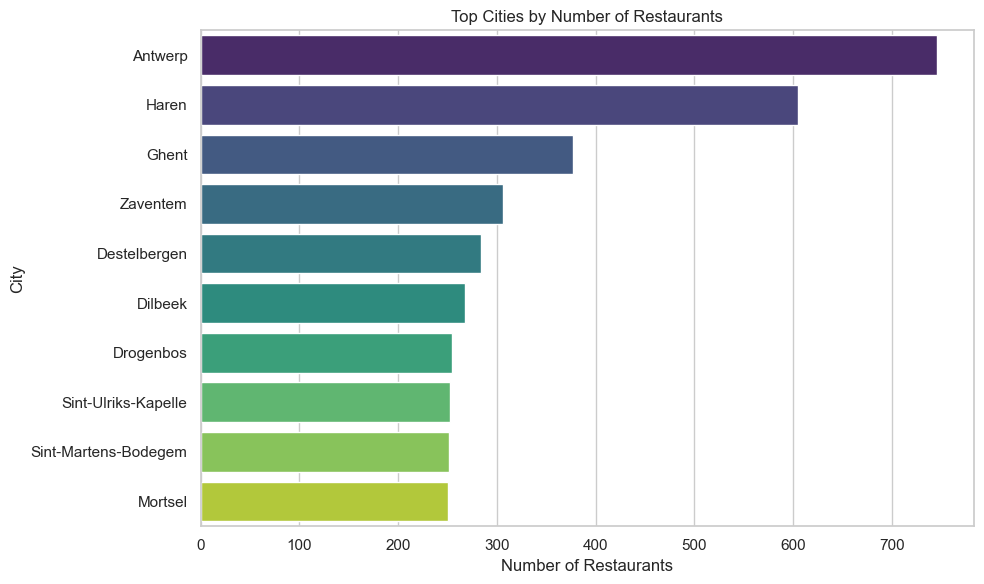

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# focus on top 10 cities
top_n = 10
df_top = df_city_dist.head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_top,
    x="restaurant_count",
    y="city",
    palette="viridis"
)

plt.title("Top Cities by Number of Restaurants")
plt.xlabel("Number of Restaurants")
plt.ylabel("City")

plt.tight_layout()
plt.show()

### 📊 Key Insights: Restaurant Distribution

| Finding | Implication |
|---------|-------------|
| **Antwerp leads with highest restaurant count** | Most competitive and saturated market |
| **Top 3 cities dominate market share** | Concentrated platform presence in major urban areas |
| **Long tail of smaller cities** | Growth potential in secondary markets |

**Business Recommendation:** New restaurants should consider entering less saturated cities where competition is lower and visibility is easier to achieve.

---

<a id='4-hummus'></a>
## 4. World Hummus Order (WHO) - Top 3 Hummus Restaurants 🥙

### Business Question
**Which restaurants serve the best hummus based on customer ratings?**

### Why It Matters
- Identifies quality leaders in a specific cuisine
- Demonstrates methodology for ranking restaurants
- Fun engagement metric for food enthusiasts!

### Methodology: Weighted Hummus Score
```
Hummus Score = Rating × log(Review Count + 1)
```

**Why this formula?**
- Rewards high ratings
- Gives more weight to restaurants with more reviews (statistical significance)
- Logarithmic scaling prevents review count from dominating
- Minimum 10 reviews required to qualify

In [6]:
# SQL query in for — Top 3 Hummus Restaurants
hummus_rest = """
SELECT 
    r.primarySlug AS restaurant_name,
    r.name AS display_name,
    r.city,
    r.ratings AS rating,
    r.ratingsNumber AS review_count,
    ROUND(r.ratings * log(r.ratingsNumber + 1), 2) AS hummus_score
FROM restaurants r
JOIN menuItems m
    ON m.primarySlug = r.primarySlug
WHERE LOWER(m.name) LIKE '%hummus%'
  AND r.ratings > 0
  AND r.ratingsNumber >= 10
GROUP BY 
    r.primarySlug,
    r.name,
    r.city,
    r.ratings,
    r.ratingsNumber
ORDER BY hummus_score DESC
LIMIT 3;
"""

# load SQL results in pandas 
df = pd.read_sql_query(hummus_rest, conn)
df

,restaurant_name,display_name,city,rating,review_count,hummus_score
0,cairo-one,Cairo One,Beveren,4.8,619,13.40
1,restaurant-le-royal,Restaurant le Royal,Bruxelles-Capitale,5.0,359,12.78
2,squadra-opdorp,Squadra Opdorp,Buggenhout (Opdorp),4.8,397,12.48


/var/folders/fz/fn63jcks2kx_4ngyvls8mp0w0000gn/T/ipykernel_81113/562416519.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


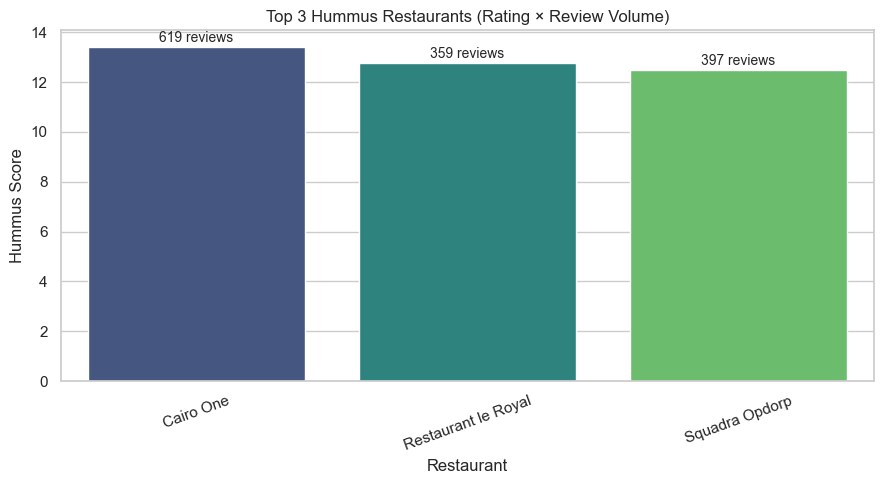

In [7]:
#  Bar chart — Top 3 Hummus Restaurants

plt.figure(figsize=(9, 5))

ax = sns.barplot(
    data=df,
    x="display_name",
    y="hummus_score",
    palette="viridis"
)

for i, row in df.iterrows():
    ax.text(
        i,
        row["hummus_score"] + 0.2,
        f'{row["review_count"]} reviews',
        ha='center',
        fontsize=10
    )

plt.title("Top 3 Hummus Restaurants (Rating × Review Volume)")
plt.xlabel("Restaurant")
plt.ylabel("Hummus Score")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

### 📊 Key Insights: World Hummus Order (WHO)

🏆 **Top 3 Hummus Champions:**

| Rank | Restaurant | City | Rating | Reviews | Score |
|------|------------|------|--------|---------|-------|
| 🥇 | Cairo One | Beveren | 4.8 | 619 | 13.40 |
| 🥈 | Restaurant le Royal | Bruxelles-Capitale | 5.0 | 359 | 12.78 |
| 🥉 | Squadra Opdorp | Buggenhout | 4.8 | 397 | 12.48 |

**Observations:**
- **Cairo One** wins despite not having a perfect 5.0 rating — high review volume compensates
- **Restaurant le Royal** has a perfect rating but fewer reviews
- All top 3 have ratings ≥ 4.8, indicating high quality across winners

**Methodology Validation:** The weighted score successfully balances quality (rating) with credibility (review volume).

---

<a id='5-veg-map'></a>
## 5. Vegetarian & Vegan Dish Availability Map 🥗

### Business Question
**How does vegetarian/vegan food availability vary across locations?**

### Why It Matters
- Plant-based diets are growing rapidly
- Identifies areas with strong/weak vegan options
- Helps health-conscious consumers find options
- Reveals market opportunities for plant-based restaurants

### Methodology
- Search menu items for keywords: 'vegetarian', 'vegan', 'veg', 'plant'
- Aggregate by location with geographic coordinates
- Visualize using clustered markers on an interactive map

### Visualization Type: Clustered Marker Map
- **Why clusters?** Prevents overcrowding when many locations are close together
- **Interactivity:** Click clusters to zoom in; click markers to see details

In [8]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import sqlite3
import webbrowser
import os

# Connect to database
conn = sqlite3.connect('takeaway.db')

# Query
veg_dish = """
SELECT
    l.city,
    l.latitude,
    l.longitude,
    COUNT(*) AS veg_vegan_dish_count
FROM locations l
JOIN locations_to_restaurants ltr
    ON l.ID = ltr.location_id
JOIN menuItems m
    ON m.primarySlug = ltr.restaurant_id
WHERE l.city IS NOT NULL
  AND l.latitude IS NOT NULL
  AND l.longitude IS NOT NULL
  AND (
        LOWER(m.name) LIKE '%vegetarian%'
     OR LOWER(m.name) LIKE '%vegan%'
     OR LOWER(m.name) LIKE '%veg%'
     OR LOWER(m.name) LIKE '%plant%'
  )
GROUP BY l.city, l.latitude, l.longitude
ORDER BY veg_vegan_dish_count DESC;
"""

df = pd.read_sql_query(veg_dish, conn)

# Create map
m = folium.Map(
    location=[52.1326, 5.2913],
    zoom_start=7,
    tiles='CartoDB positron'
)

# Create marker cluster
marker_cluster = MarkerCluster(name="Veg/Vegan Locations").add_to(m)

# Add markers to cluster
for _, row in df.iterrows():
    folium.Marker(
        location=[row["latitude"], row["longitude"]],
        popup=f"<b>{row['city']}</b><br>Dishes: {row['veg_vegan_dish_count']}",
        tooltip=f"{row['city']}: {row['veg_vegan_dish_count']} dishes",
        icon=folium.Icon(color='green', icon='leaf', prefix='fa')
    ).add_to(marker_cluster)

# Save and open
m.save('veg_map_clustered.html')
file_path = os.path.abspath('veg_map_clustered.html')
webbrowser.open('file://' + file_path)
print("Clustered map opened! ✅")

Clustered map opened! ✅


### 📊 Key Insights: Vegetarian & Vegan Availability

| Finding | Implication |
|---------|-------------|
| **Major cities have highest veg/vegan options** | Urban areas lead in plant-based offerings |
| **Cluster density varies significantly** | Some regions are "vegan deserts" |
| **Coastal and university cities perform well** | Younger demographics drive demand |

**Business Recommendation:** 
- Plant-based restaurants should target underserved suburban areas
- Existing restaurants in low-density areas could add vegan options to capture unmet demand

**Map Interaction Tips:**
- 🖱️ Click on clusters to zoom in
- 📍 Click individual markers to see city details
- 🔍 Use scroll to zoom in/out

---

## 📋 Summary & Conclusions

### Key Findings

1. **Pricing Strategy:** The platform is positioned for mid-range consumers (€5-€15), with opportunities at budget and premium ends.

2. **Geographic Concentration:** Restaurant supply is heavily concentrated in major cities like Antwerp, with significant growth potential in secondary markets.

3. **Quality Leaders:** Top-rated restaurants (like Cairo One for hummus) combine high ratings with substantial review volumes.

4. **Plant-Based Gap:** Vegetarian/vegan options cluster in urban areas, leaving suburban regions underserved.

### Recommendations

| Stakeholder | Recommendation |
|-------------|----------------|
| **New Restaurants** | Consider entering less saturated cities |
| **Existing Restaurants** | Add plant-based options to capture growing demand |
| **Platform (Takeaway)** | Incentivize restaurant expansion to underserved areas |
| **Consumers** | Use this analysis to discover top-rated options in your area |

---

*Analysis completed using Python, SQLite, Pandas, Matplotlib, Seaborn, and Folium.*

In [9]:
# Close database connection
conn.close()
print("Database connection closed! ✅")

Database connection closed! ✅
